In [3]:
# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

In [1]:
import networkx as nx
import pandas as pd
import psycopg2

In [2]:
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import os

os.environ["JAVA_HOME"] = "/usr/local/opt/openjdk@11/"

findspark.init("./spark-3.2.0-bin-hadoop3.2")

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/15 15:40:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
vertices = spark.createDataFrame([
    ("a", "Alice", 34),
    ("b", "Bob", 36),
    ("c", "Charlie", 30),
    ("d", "David", 29),
    ("e", "Esther", 32),
    ("f", "Fanny", 36),
    ("g", "Gabby", 60),
], ["id", "name", "age"])
edges = spark.createDataFrame([
    ("a", "b", "friend"),
    ("b", "c", "follow"),
    ("c", "b", "follow"),
    ("f", "c", "follow"),
    ("e", "f", "follow"),
    ("e", "d", "friend"),
    ("d", "a", "friend"),
    ("a", "e", "friend")
], ["src", "dst", "relationship"])

In [7]:
g = GraphFrame(vertices, edges)

In [9]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [10]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [13]:
def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw(g, with_labels=True, arrows = True, node_color='grey')

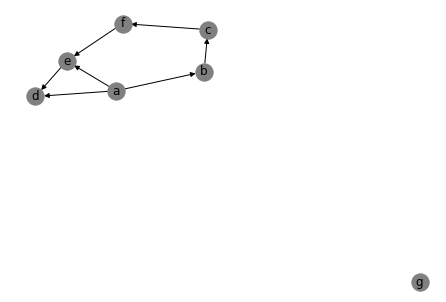

In [15]:
plot_graph(g)

In [19]:
g.inDegrees.sort(['inDegree'], ascending=[0]).show()

+---+--------+
| id|inDegree|
+---+--------+
|  c|       2|
|  b|       2|
|  f|       1|
|  d|       1|
|  e|       1|
|  a|       1|
+---+--------+



In [18]:
g.outDegrees.sort(['outDegree'], ascending=[0]).show()

+---+---------+
| id|outDegree|
+---+---------+
|  e|        2|
|  a|        2|
|  b|        1|
|  c|        1|
|  d|        1|
|  f|        1|
+---+---------+



In [20]:
g.degrees.sort(['Degree'], ascending=[0]).show()

+---+------+
| id|degree|
+---+------+
|  b|     3|
|  e|     3|
|  a|     3|
|  c|     3|
|  f|     2|
|  d|     2|
+---+------+



In [25]:
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI",
)
cursor = conn.cursor()

In [26]:
edges_query = """
    SELECT da1.officer_id src, da2.officer_id dst, COUNT(DISTINCT da1.allegation_id) relationship
    FROM data_officerallegation da1
    JOIN data_officerallegation da2 
        ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id 
    GROUP BY da1.officer_id, da2.officer_id
    ORDER BY count(*) DESC;
"""

In [28]:
nodes_query = """
    SELECT  id, first_name || ' ' || last_name officer_name, allegation_count
    FROM data_officer;
"""

In [30]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 17465

df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

print(df_edges.shape)

shape is: 229195
(229195, 3)


In [31]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 17465

df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

print(df_nodes.shape)

shape is: 35545
(35545, 3)


In [34]:
edges_ = spark.createDataFrame(df_edges)
nodes = spark.createDataFrame(df_nodes)

In [35]:
cpdb = GraphFrame(nodes, edges_)

In [37]:
cpdb.vertices.show()

+-----+---------------+----------------+
|   id|   officer_name|allegation_count|
+-----+---------------+----------------+
|32312|   Randall Ryan|            10.0|
|32358|    Kevin Stoll|            24.0|
|32480|    David Lavin|             0.0|
|32491|     Kevin Rake|             0.0|
| 2680| Richard Brandt|             0.0|
|29553| Hugh Versteegh|             0.0|
|19974|  Andrew Murcia|             0.0|
| 8259|    Hugh Farmer|             0.0|
|17716|Anthony Matassa|             0.0|
|19659|  John Moriarty|             0.0|
|32506|Richard Francis|             0.0|
|29111|   Robert Tyson|             0.0|
| 1791|  Chas Bennette|             0.0|
|17146|  Robert Malone|             0.0|
|17242|  Jerry Manning|             0.0|
|17289|Michael Maratto|             0.0|
|32467|  Jonathan Boyd|             0.0|
|33755|Phyllis Butcher|             1.0|
|  333|Leroy Alexander|             0.0|
|18597|  James Mcglynn|             0.0|
+-----+---------------+----------------+
only showing top

In [38]:
cpdb.edges.show()

+-----+-----+------------+
|  src|  dst|relationship|
+-----+-----+------------+
|12478|32166|          53|
| 8562|27778|          47|
| 1553|10724|          43|
| 2725|21703|          41|
| 3605|14442|          41|
|12479|20713|          40|
| 8658|13788|          38|
|14045|15502|          37|
| 2369| 7015|          36|
| 1553|16699|          35|
|12074|12825|          35|
| 8852|31119|          35|
|15360|23239|          34|
|13361|20150|          34|
| 8562|23841|          32|
| 8562|18206|          32|
|32265|32347|          32|
|31882|32401|          32|
|31119|32336|          32|
|27415|32172|          31|
+-----+-----+------------+
only showing top 20 rows



In [40]:
cpdb.vertices.sort(['id'], ascending=True).show()

+---+-----------------+----------------+
| id|     officer_name|allegation_count|
+---+-----------------+----------------+
|  1|    Jeffery Aaron|             6.0|
|  2|     Karina Aaron|             8.0|
|  3|     Daniel Abate|             0.0|
|  4|    Carmel Abbate|             7.0|
|  5|    Carmen Abbate|             4.0|
|  6|   Anthony Abbate|             6.0|
|  7|     Terry Abbate|             8.0|
|  8|       Leon Abbey|             2.0|
|  9|    Michael Abbey|             3.0|
| 10|       Leon Abbey|             0.0|
| 11|     Laura Abbott|             7.0|
| 12|    Andrew Abbott|             7.0|
| 13|      Dale Abbott|            10.0|
| 14| Elizabeth Abbott|             4.0|
| 15|    Zaid Abdallah|             1.0|
| 16| Aziz Abdelmajeid|            19.0|
| 17|  Moulay Abdullah|            25.0|
| 18|    Jason Abejero|             5.0|
| 19|Restituto Abejero|             5.0|
| 20|    Kenneth Abels|             3.0|
+---+-----------------+----------------+
only showing top

In [41]:
tc_cpdb = cpdb.triangleCount()
tc_cpdb.select("id", "count").show()

+-----+-----+
|   id|count|
+-----+-----+
|19659|    0|
| 8259|    0|
|33755|    0|
|17716|    0|
|33725|    0|
|32506|    0|
|17146|    0|
|  333|    0|
|17289|    0|
| 2680|    0|
|19974|    0|
|17242|    0|
|32491|    0|
|32312|   37|
|32358|  109|
|32480|    0|
| 1791|    0|
|18597|    0|
|29553|    0|
|29111|    0|
+-----+-----+
only showing top 20 rows



In [42]:
pr_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)
#look at the pagerank score for every vertex
pr_cpdb.vertices.orderBy('pagerank', ascending=False).show()

+-----+------------------+----------------+------------------+
|   id|      officer_name|allegation_count|          pagerank|
+-----+------------------+----------------+------------------+
|32442|      John Zinchuk|            23.0|165.10729586039054|
|32440|       Mark Zawila|            34.0|116.94160976160474|
|32425|    Perry Williams|            27.0| 98.30895865467448|
|32350|    Robert Spiegel|            20.0| 93.89434875346458|
|32410|     Joseph Watson|            29.0| 93.08113520834976|
|32430|    Michael Wrobel|            22.0| 91.40650266021781|
|32074|    Ronald Jenkins|            46.0| 90.96964645851831|
|32284|         Mark Reno|            76.0| 88.61011443214588|
|32351|  Boonserm Srisuth|            25.0|  85.7484496585607|
|32433|     Kenneth Yakes|            29.0| 82.53441261166478|
|32419|         Eric Wier|            18.0| 78.00667585858889|
|32384|     Edwin Utreras|            47.0| 77.30836139097354|
|32435|    Mohammad Yusuf|            22.0|  76.7888150

In [44]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM
# from graphframes.examples import Graphs
# g = Graphs(sqlContext).friends()  # Get example graph

# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["allegation_count"]
msgToDst = AM.src["allegation_count"]
agg = cpdb.aggregateMessages(
    sqlsum(AM.msg).alias("summedAllegations"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['id'], ascending=True).show()

+---+-----------------+
| id|summedAllegations|
+---+-----------------+
|  1|            101.0|
|  2|            301.0|
|  4|             24.0|
|  5|            293.0|
|  6|            273.0|
|  7|            347.0|
|  8|            156.0|
|  9|             13.0|
| 11|            138.0|
| 12|            383.0|
| 13|            149.0|
| 14|             54.0|
| 15|             90.0|
| 16|            987.0|
| 17|            208.0|
| 18|             33.0|
| 19|             27.0|
| 20|             37.0|
| 21|            114.0|
| 25|              7.0|
+---+-----------------+
only showing top 20 rows

